In [3]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [5]:
import kagglehub

path = kagglehub.dataset_download("hmsolanki/indian-languages-audio-dataset")
print("Path to dataset files:", path)


100%|███████████████████████████████████████████████████████████████████████████████| 713M/713M [09:45<00:00, 1.28MB/s]

Extracting files...


Path to dataset files: C:\Users\hp\.cache\kagglehub\datasets\hmsolanki\indian-languages-audio-dataset\versions\1


In [34]:
import os
import numpy as np
import librosa
import random
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from librosa.effects import pitch_shift
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# LOAD HINDI AUDIO FILES
real_dir = "C:/Users/hp/.cache/kagglehub/datasets/hmsolanki/indian-languages-audio-dataset/versions/1/Indian_Languages_Audio_Dataset/Hindi"
audio_files = [os.path.join(real_dir, f) for f in os.listdir(real_dir) if f.endswith('.wav') or f.endswith('.mp3')]

In [41]:
# FAKE AUDIO FUNCTIONS
def add_noise(data, noise_level=0.005):
    noise = np.random.randn(len(data))
    return data + noise_level * noise

def shift_pitch(data, sr, n_steps=2):
    return librosa.effects.pitch_shift(y=data, sr=sr, n_steps=n_steps)

def stretch_audio(data, rate=1.2):
    return librosa.effects.time_stretch(y=data, rate=rate)


In [48]:
# FEATURE EXTRACTION LOOP
X = []
y = []  # 0 = real, 1 = fake

for file_path in audio_files:
    try:
        y_real, sr = librosa.load(file_path, duration=3.0)
        mfcc = librosa.feature.mfcc(y=y_real, sr=sr, n_mfcc=13)
        X.append(np.mean(mfcc.T, axis=0))
        y.append(0)

        # Generate fake samples
        for fake in [shift_pitch(y_real, sr), stretch_audio(y_real), add_noise(y_real)]:
            mfcc_fake = librosa.feature.mfcc(y=fake, sr=sr, n_mfcc=13)
            X.append(np.mean(mfcc_fake.T, axis=0))
            y.append(1)

    except Exception as e:
        print(f"Error with file {file_path}: {e}")

In [49]:
X = np.array(X)
y = np.array(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [51]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
print("Labels count:", np.bincount(y))

Labels count: [1000 3000]


Accuracy: 72.75 %


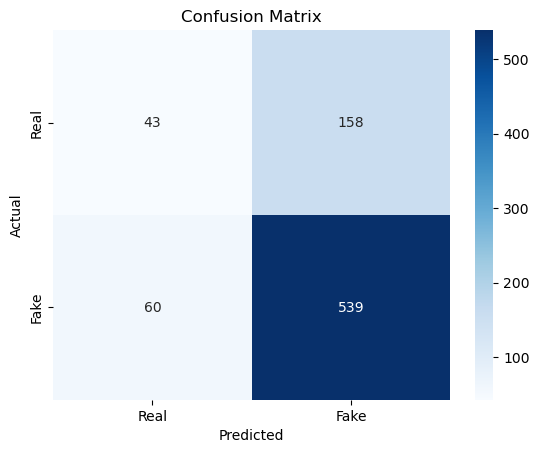

In [50]:
y_pred = model.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", round(acc * 100, 2), "%")

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
